# Exoplanet Classification - COGS 118B Final

## Import Necessary Libraries

In [4]:
import numpy as np
import pandas as pd
from numpy.random import seed
from tensorflow import set_random_seed
import tensorflow as tf
from sklearn.metrics import *
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, GRU, Flatten, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

## Define Model Architecture

In [5]:
def model(input_shape):
    
    #Define Input Layer
    X_input = Input(shape = input_shape)
    
    #Perform a 1D Convolution To Detect Features and Reduce Dimensionality
    X = Conv1D(32, kernel_size=10, strides=4)(X_input)
    X = MaxPooling1D(pool_size=4, strides=2)(X)
    X = Activation('relu')(X)
    
    #Pass Input Through GRU with Hidden Size 192
    X = GRU(192,return_sequences=True)(X)
    X = Flatten()(X)
    
    # Regularize Model With Dropout
    X = Dropout(0.5)(X)            

    #Additional Regularization with BatchNorm                     
    X = BatchNormalization()(X)   

    #Calculate Class Probability Score 
    X = Dense(1, activation="sigmoid")(X)

    #Initialize Model Object
    model = Model(inputs=X_input, outputs = X)
    
    return model  

## Process Training and Testing Data

### Perform Data Augmentation

In [6]:
def augment(df, num_to_generate):
    
    #Select All Positive Examples
    positive_examples = df.loc[df['LABEL'] == 2]
    
    #Initialize Array to Store Augmented Values
    augmented = []
    
    #Generate augmented data 
    for _ in tqdm(range(num_to_generate)):
        
        #Select a random positive example
        sample_idx = np.random.randint(0, len(positive_examples))
        
        #Create a copy of the selected observation
        new_data = positive_examples.iloc[sample_idx][1:].copy()
                
        #Add gaussian noise to the observation
        data = new_data + np.random.normal(20, 1, size=new_data.shape)
        
        #Append augmented observation to array
        augmented.append(data)
    
    #Create dataframe from 2-d array
    ad = pd.DataFrame(augmented)
    
    #Set all labels as positive
    ad['LABEL'] = [2 for _ in range(ad.shape[0])]
    
    return ad

### Load Training Data

In [7]:
#Perform Train Data Processing
train = pd.read_csv("./data/exoTrain.csv")

#Create 400 Augmented Data Points
augmented = augment(train, 400)

#Append the augmented data points to the training set
train = train.append(augmented)

#Get the number of observations and features in train set
N_train, M_train = train.shape

#Reduce Number of Features by 1 | To account for Label Col
M_train -= 1

#Store Training Labels
y_train = train['LABEL'].values

#Turn Labels from (1,2) to (0,1)
y_train -=1

#Store Training Data
X_train = train.drop('LABEL', axis=1).values.reshape(N_train, M_train, 1)

100%|██████████| 400/400 [00:01<00:00, 394.89it/s]
/Users/icpc/.pyenv/versions/3.6.3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


### Load Testing Data

In [8]:
#Load data from test csv into a dataframe
test = pd.read_csv("./data/exoTest.csv")

#Get the shape of the test dataset
N_test, M_test = test.shape

#Subtract by 1 to account for label column
M_test -= 1

#Extract the label values as integers
y_test = test['LABEL'].values

#Subtract 1 from the label vector to turn labels from (1,2) to (0,1)
y_test -= 1

#Expand Dimensions 
X_test = test.drop('LABEL',axis=1).values.reshape(N_test, M_test, 1)

In [9]:
#Set a seed for reproducability
seed(42)
set_random_seed(42)

#Initialize GRU Model
gru_model = model(input_shape = (3197, 1))

#Initialize an Adam Optimizer 
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)

#Compile Model with BCE Loss and Optimizer
gru_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

#Print A Summary of the Model Architecture
gru_model.summary()

#Store the class weights to account for the dataset imbalance
class_weight = {0: 1., 1: 4}

#Fit Model to Training Data and Validate on Test Set
#history = gru_model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=128, epochs=5, shuffle=True, class_weight=class_weight)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3197, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 797, 32)           352       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 397, 32)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 397, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 397, 192)          129600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 76224)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 76224)             0         
__________

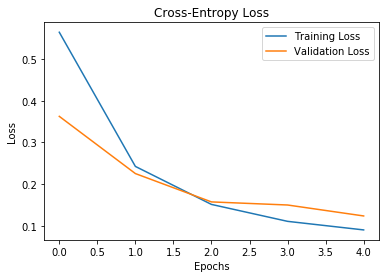

In [49]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Cross-Entropy Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

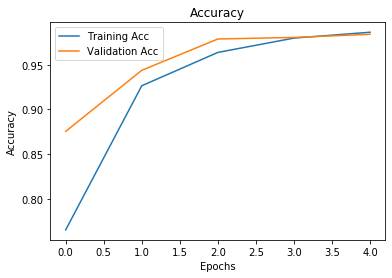

In [50]:
plt.plot(history.history['acc'], label="Training Acc")
plt.plot(history.history['val_acc'], label="Validation Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

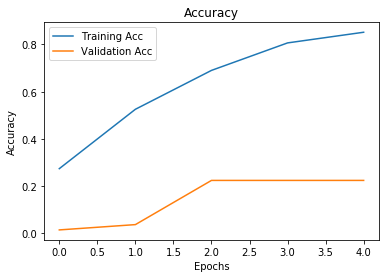

In [63]:
plt.plot(history.history['precision_m'], label="Training Acc")
plt.plot(history.history['val_precision_m'], label="Validation Acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [51]:
preds = gru_model.predict(X_test)

In [74]:
idxs = (preds > 0.5).astype(int)

In [77]:
print("F1:", f1_score(y_test, idxs, average="weighted"))
print("Precision:", precision_score(y_test, idxs, average="weighted"))
print("Recall:", recall_score(y_test, idxs, average="weighted"))

F1: 0.9849212369840779
Precision: 0.9856600721662313
Recall: 0.9842105263157894


In [91]:
fpr, tpr, _ = roc_curve(y_test, preds)

0.9842105263157894

Text(0, 0.5, 'True Positive Rate')

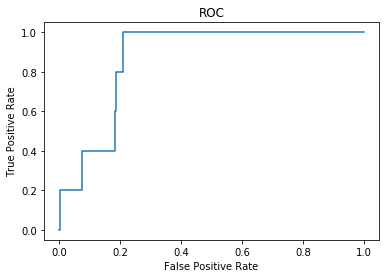

In [89]:
plt.plot(fpr, tpr)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [67]:
plot_model(gru_model, to_file="architecture.png")